Autor: Gustavo Vilela Mitraud <br>
Universidade Presbiteriana Mackenzie

In [13]:
import pandas as pd
from matplotlib import pyplot as plt

df_steam = pd.read_csv("archive\steam.csv")
df_steam

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


Será dado um ID para cada valor em string em cada categoria. <br>
Por exemplo, Valve será igual a 1, Gearbox Software será igual a 2 e assim por diante

In [14]:
def create_ids(lst):
    lst_set = set()
    lst_ids = dict()

    for name in lst:
        if name not in lst_set:
            lst_set.add(name)
    
    for i, name in enumerate(lst_set):
        lst_ids[i] = name

    return lst_ids

dev_lookup = create_ids(df_steam["developer"])
publisher_lookup = create_ids(df_steam["publisher"])


Usando o IF-IDF para achar a similaridade entre os valores das categories "platforms" e "steamspy_tags

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
tf_idf_vectorizer = TfidfVectorizer()
def similarity(text_lst):
    tf_idf_transform = tf_idf_vectorizer.fit_transform(text_lst)
    return cosine_similarity(tf_idf_transform)

cos_sim_platforms = similarity(df_steam["platforms"])
cos_sim_tags = similarity(df_steam["steamspy_tags"])
    
    

Criando o dataframe que sera usado para a recomendação

In [23]:
def transform_to_id(dict_of_ids, lst):
    list_of_ids = []
    keys = list(dict_of_ids.keys())
    values = list(dict_of_ids.values())
    for name in lst:
        list_of_ids.append(keys[values.index(name)])
    
    return list_of_ids

dev_ids = transform_to_id(dev_lookup, df_steam["developer"])
publisher_ids = transform_to_id(publisher_lookup, df_steam["publisher"])

popularity = [x.split("-")[1] for x in df_steam["owners"]]
positive_ratio = [pos-neg for pos,neg in zip(df_steam["positive_ratings"], df_steam["negative_ratings"])]
data_dict = {"dev_ids": dev_ids, "publisher_ids": publisher_ids, "platforms_sim": list(cos_sim_platforms[0]), "tags_sim": list(cos_sim_tags[0]), "popularity": popularity, "positive_ratio": positive_ratio}

data_df = pd.DataFrame(data_dict)
data_df

,dev_ids,publisher_ids,platforms_sim,tags_sim,popularity,positive_ratio
0,9876,8350,1.000000,1.000000,20000000,121195
1,9876,8350,1.000000,1.000000,10000000,2685
2,9876,8350,1.000000,0.537860,10000000,3018
3,9876,8350,1.000000,1.000000,10000000,1006
4,16918,8350,1.000000,0.420275,10000000,4962
...,...,...,...,...,...,...
27070,14642,12327,0.278753,0.000000,20000,3
27071,14860,10843,0.278753,0.161619,20000,7
27072,16424,13766,0.278753,0.163285,20000,-1
27073,3098,52,0.676292,0.000000,20000,2


normalizando a base de dados

In [27]:
from sklearn.preprocessing import Normalizer
import numpy as np

normalizer = Normalizer()
data_df = normalizer.fit_transform(data_df)
pd.DataFrame(data_df)


,0,1,2,3,4,5
0,0.000494,0.000417,4.999907e-08,4.999907e-08,0.999981,0.006060
1,0.000988,0.000835,9.999991e-08,9.999991e-08,0.999999,0.000268
2,0.000988,0.000835,9.999991e-08,5.378591e-08,0.999999,0.000302
3,0.000988,0.000835,9.999992e-08,9.999992e-08,0.999999,0.000101
4,0.001692,0.000835,9.999981e-08,4.202742e-08,0.999998,0.000496
...,...,...,...,...,...,...
27070,0.528919,0.445293,1.006950e-05,0.000000e+00,0.722468,0.000108
27071,0.546860,0.399031,1.025833e-05,5.947693e-06,0.736016,0.000258
27072,0.560298,0.469621,9.509546e-06,5.570406e-06,0.682292,-0.000034
27073,0.153074,0.002569,3.341598e-05,0.000000e+00,0.988211,0.000099


Aplicado o algoritmo K-means no dataframe

In [28]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(2)

reshaped_data = pca.fit_transform(data_df)
reshaped_data.shape

(27075, 2)

In [29]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10)
clusters = k_means.fit_predict(reshaped_data)
clusters

c:\Users\gus_v\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([6, 6, 6, ..., 8, 1, 6])

<function matplotlib.pyplot.show(close=None, block=None)>

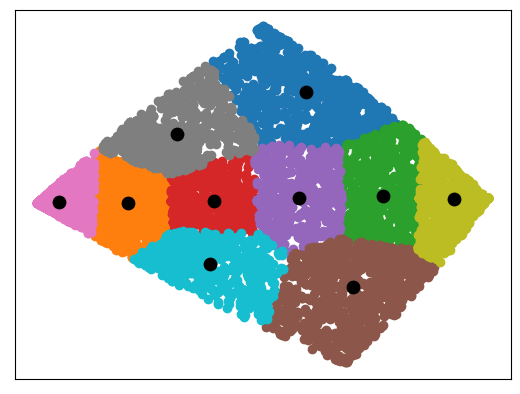

In [30]:
centroids = k_means.cluster_centers_
unique_clusters = np.unique(clusters)
for i in unique_clusters:
    plt.scatter(reshaped_data[clusters == i, 0], reshaped_data[clusters == i, 1], label = i)
plt.scatter(centroids[:,0], centroids[:,1], s = 80, color = "k")
plt.yticks(())
plt.xticks(())
plt.show

Agora vamos testar o modelo

In [31]:
lookup_recomendation = {"game_name": [x.lower() for x in df_steam["name"]], "cluster": clusters}
lookup_recomendation = pd.DataFrame(lookup_recomendation)
lookup_recomendation

,game_name,cluster
0,counter-strike,6
1,team fortress classic,6
2,day of defeat,6
3,deathmatch classic,6
4,half-life: opposing force,6
...,...,...
27070,room of pandora,8
27071,cyber gun,8
27072,super star blast,8
27073,new yankee 7: deer hunters,1


In [32]:
import random

def get_recomendation(game):
    cluster_to_recomend = int(lookup_recomendation.loc[lookup_recomendation["game_name"]==game]["cluster"])
    list_of_games = list(lookup_recomendation.loc[lookup_recomendation["cluster"]==cluster_to_recomend]["game_name"])
    return random.sample(list_of_games, 5)

get_recomendation("Counter-Strike".lower())

['switch galaxy ultra',
 'deep space waifu',
 'sparkle zero',
 'tunnels of despair',
 'pickcrafter']